# 1. Data Preparation


This first step will involve acquiring all the relevant datasets from source. These will be  loaded into  Pandas and then merged into a single dataframe.

## 1.1 Loading the datasets

We will be using Bike Share Toronto Data from 2018 - 2020. These comprise several different files. Both the 2018 and 2019 data comprise 4 files, each representing a single quarter for the year in question, while the 2020 data is comprised of 12 files, representing each month in the year. We will begin by loading all the individual datasets.

In [24]:
#Import the relevant libraries
import pandas as pd
import numpy as np
#import modin.pandas as pd
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import requests
import json
from os import listdir
from geopy import distance
import warnings
warnings.filterwarnings('ignore')
#import ray

In [35]:
#Extract the file path for each folder containing each year's data
filepaths2020 = ["./bikeshare2020/"+f for f in listdir("./bikeshare2020") if f.endswith('.csv')]
filepaths2019 = ["./bikeshare2019/"+f for f in listdir("./bikeshare2019") if f.endswith('.csv')]
filepaths2018 = ["./bikeshare2018/"+f for f in listdir("./bikeshare2018") if f.endswith('.csv')]

In [36]:
df2020 = pd.concat(map(pd.read_csv, filepaths2020),ignore_index=True)
df2019 = pd.concat(map(pd.read_csv, filepaths2019),ignore_index=True)
df2018 = pd.concat(map(pd.read_csv, filepaths2018),ignore_index=True)

In [37]:
df2018.head()

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type
0,2383648,393,7018,1/1/2018 0:47,Bremner Blvd / Rees St,1/1/2018 0:54,7176,Bathurst St / Fort York Blvd,Annual Member
1,2383649,625,7184,1/1/2018 0:52,Ossington Ave / College St,1/1/2018 1:03,7191,Central Tech (Harbord St),Annual Member
2,2383650,233,7235,1/1/2018 0:55,Bay St / College St (West Side) - SMART,1/1/2018 0:59,7021,Bay St / Albert St,Annual Member
3,2383651,1138,7202,1/1/2018 0:57,Queen St W / York St (City Hall),1/1/2018 1:16,7020,Phoebe St / Spadina Ave,Annual Member
4,2383652,703,7004,1/1/2018 1:00,University Ave / Elm St,1/1/2018 1:12,7060,Princess St / Adelaide St E,Annual Member


In [38]:
mixedcols = df2020[df2020["Bike Id"]=="Annual Member"]
mixedcols.head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
328017,10000084625,7120,10/03/2020 13:28,Gerrard St E / River St,7120,10/03/2020 13:38,Gerrard St E / River St,5250,Annual Member,NaN
328214,10000306555,7120,10/03/2020 13:38,Gerrard St E / River St,7576,10/03/2020 13:48,Front St E / Bayview Avenue,5250,Annual Member,NaN
328406,10000519608,7576,10/03/2020 13:48,Front St E / Bayview Avenue,7357,10/03/2020 13:58,Lake Shore Blvd E / Leslie St,5250,Annual Member,NaN
328625,10000755851,7357,10/03/2020 13:58,Lake Shore Blvd E / Leslie St,7313,10/03/2020 14:12,Coxwell Ave / Lake Shore Blvd E,5250,Annual Member,NaN
328937,10001076784,7313,10/03/2020 14:12,Coxwell Ave / Lake Shore Blvd E,7317,10/03/2020 14:26,Hubbard Blvd / Balsam Av,5250,Annual Member,NaN


While the 2018 and 2019 datasets appear to be fine, the 2020 dataset has an issue where some columns contain data from other columns. From the example above, the Bike Id column contains data from the User Id column and so on. This affects 249 rows, so these can be removed from the dataset.

In [39]:
print(len(mixedcols))

249


In [40]:
#Removing data with wrong column entries in the 2020 dataset
df2020.drop(df2020[df2020["Bike Id"] == "Annual Member"].index, inplace=True)

Also, the 2019 and 2020 dataset has a Bike Id column while 2018 doesn't. For consistency, the Bike Id column will be dropped from the 2020 dataset.

In [41]:
#Dropping the Bike Id column from the 2019 and 2020 datasets
df2019.drop('Bike Id', axis=1, inplace=True)
df2020.drop('Bike Id', axis=1, inplace=True)


Next, we will rename the columns for all 3 datasets for consistency.

In [42]:
#Renaming columns for all datasets
df2018.columns = ['Trip ID', 'Trip Duration', 'Start Station ID', 'Start Time','Start Station Name', 'End Time','End Station ID', 'End Station Name','User Type']
df2019.columns = ['Trip ID', 'Trip Duration', 'Start Station ID', 'Start Time','Start Station Name','End Station ID','End Time', 'End Station Name','User Type']
df2020.columns = ['Trip ID', 'Trip Duration', 'Start Station ID', 'Start Time','Start Station Name','End Station ID','End Time', 'End Station Name','User Type']

In [43]:
#change order of columns for 2018 data so it matches that of 2019 and 2020
df2018 = df2018[['Trip ID', 'Trip Duration', 'Start Station ID', 'Start Time','Start Station Name','End Station ID','End Time', 'End Station Name','User Type']]

In [44]:
#Merge all three datasets into one.
df = pd.concat([df2018,df2019,df2020],ignore_index = True)

## 1.2 Cleaning the dataset

This section will explore some characteristics of the dataset to determing if it needs further cleaning and transformation.

In [45]:
#Check the number of rows and columns
df.shape

(7273531, 9)

In [46]:
#Check the column attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7273531 entries, 0 to 7273530
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Trip ID             int64  
 1   Trip Duration       float64
 2   Start Station ID    object 
 3   Start Time          object 
 4   Start Station Name  object 
 5   End Station ID      object 
 6   End Time            object 
 7   End Station Name    object 
 8   User Type           object 
dtypes: float64(1), int64(1), object(7)
memory usage: 499.4+ MB


### 1.2.1 Missing values

In [47]:
#Check the presence of null values for every column in the dataset
df.isnull().sum()

Trip ID                  0
Trip Duration           16
Start Station ID         0
Start Time               0
Start Station Name     793
End Station ID        1755
End Time                 0
End Station Name      2503
User Type                0
dtype: int64

In [48]:
#Total number of missing values
df.isnull().sum().sum()

5067

The dataset contains a total of 5067 null values. Given the overall size of the dataset, these rows can be dropped as they will not have a significant effect on the overall results of our analysis.

In [49]:
#Remove all null values from the dataset
df = df.dropna()

In [50]:
#Do a final check for missing values
df.isnull().sum()

Trip ID               0
Trip Duration         0
Start Station ID      0
Start Time            0
Start Station Name    0
End Station ID        0
End Time              0
End Station Name      0
User Type             0
dtype: int64

In [51]:
#Check the total length of data set
df.shape[0]

7270241

### 1.2.2 Outliers

In [52]:
#Check summary statistics of the Trip Duration column
df['Trip Duration'].describe()

count    7.270241e+06
mean     1.069985e+03
std      1.156862e+04
min      0.000000e+00
25%      4.440000e+02
50%      7.340000e+02
75%      1.157000e+03
max      1.240378e+07
Name: Trip Duration, dtype: float64

The Trip Duration ranges from 0 second to 1,240,378 seconds (14days). This suggests the presence of corrupted data points and outliers. We will begin by removing all trips that are less than 60 seconds. These trips are considered to be "false starts" and do not represent a completed bike trip.

In [53]:
#Remove bike trips that are less than 60 seconds.
df = df[(df['Trip Duration']>=60)]

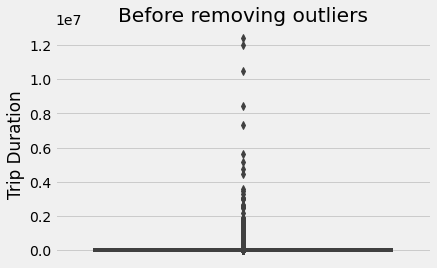

In [54]:
sns.boxplot(y=df["Trip Duration"]).set(title="Before removing outliers")
plt.show()

Next, we will check the dataset for the presence of outliers. One common way to identify outliers in a dataset is by utilizing the Inter-Quartile Range (IQR). The IQR represents the middle 50% of the data, and generally, data points that are +-1.5*IQR away from the median are considered to be outliers.  

In [55]:
#Remove outliers using the IQR method
q1 = df['Trip Duration'].quantile(0.25)
q3 = df['Trip Duration'].quantile(0.75)

iqr = q3 - q1

df = df[~((df['Trip Duration'] < (q1 - 1.5 * iqr)) \
         |(df['Trip Duration'] > (q3 + 1.5 * iqr)))].reset_index(drop=True)

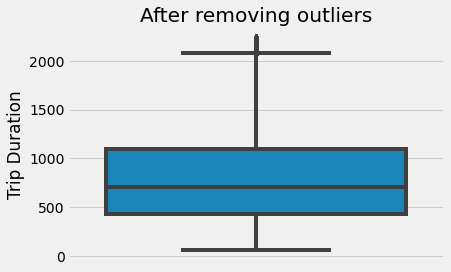

In [56]:
sns.boxplot(y=df["Trip Duration"]).set(title="After removing outliers")
plt.show()

In [57]:
len(df)

6945809

In [208]:
#Saving cleansed dataset
df.to_csv("bikeshare_cleaned.csv",index=False)

## 1.3 Transforming the Dataset

In this section we will transform the data by adding additional columns. We will begin by including latitude and longitude coordinates to give us geospacial information. Bike Share Toronto makes this data available in JSON format through an API endpoint.

In [25]:
df = pd.read_csv("bikeshare_cleaned.csv")

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6944160 entries, 0 to 6944159
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Trip ID             int64  
 1   Trip Duration       float64
 2   Start Station ID    int64  
 3   Start Time          object 
 4   Start Station Name  object 
 5   End Station ID      float64
 6   End Time            object 
 7   End Station Name    object 
 8   User Type           object 
dtypes: float64(2), int64(2), object(5)
memory usage: 476.8+ MB


In [12]:
#Convert end station ID to integer
df["End Station ID"] = df["End Station ID"].astype(int)

In [13]:
#Use the request library to request data from the API endpoint
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')

In [14]:
#Create a dataframe from the resulting json data
stations = pd.DataFrame(json.loads(r.content)['data']['stations'])[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'int64',
})

In [15]:
stations.head()

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Wellesley Station Green P,43.664964,-79.383550
2,7002,St. George St / Bloor St W,43.667333,-79.399429
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761
4,7004,University Ave / Elm St,43.656518,-79.389099


In [16]:
#Merge the stations data to the bikeshare dataset by performing an inner join.
df = df.merge(stations[['station_id','lat','lon']], how='inner', left_on='Start Station ID', right_on='station_id')\
        .merge(stations[['station_id','lat','lon']], how='inner',left_on='End Station ID',right_on='station_id')

In [17]:
#Clean up the dataframe by dropping duplicate columns, and renaming and rearranging remaining columns
df.drop(['station_id_x','station_id_y'],axis=1,inplace=True)
df.rename(columns={'lat_x':'Start Station Latitude','lon_x':'Start Station Longitude','lat_y':'End Station Latitude','lon_y':'End Station Longitude'},inplace=True)


Next, we will change the Start Time and End Time columns to datetime objects, and then extract date and time attributes into new columns.

In [185]:
#Convert Start Time and End Time columns to datetime objects
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])

In [186]:
#Create additional columns by extracting datetime attributes
df["Date"] = df["Start Time"].dt.date
df["Time"] = df["Start Time"].dt.time
df["Day of Week"] = df['Start Time'].dt.day_name()
df["Hour"] = df['Start Time'].dt.hour
df["Month"] = df['Start Time'].dt.month_name()
df["Year"] = df['Start Time'].dt.year
df["Quarter"] = df['Start Time'].dt.quarter


In [187]:
#Create a Weekend column to denote if ride was taken on a weekend or not.
df['Weekend'] = np.where(df["Start Time"].dt.weekday > 4,"Weekend","Weekday")

Next, we will create a Holiday column to identify if a trip was taken on a holiday or not. First, we will read in a dataset containing all official holidays in Canada from 2012.

In [188]:
#Load dataset containing a list of all public Holidays from 2012
holidays = pd.read_csv("/Users/sig/Desktop/Capstone/holidays.csv")

In [189]:
holidays.head()

,date,holiday
0,2012-01-02,New Year's Day
1,2012-02-20,Family Day
2,2012-04-06,Good Friday
3,2012-05-21,Victoria Day
4,2012-07-02,Canada Day


In [190]:
#Create a subset of the holidays dataframe that includes only holidays from  2018 to 2020.
holidays_filtered = (holidays["date"] >= '2018') & (holidays["date"] < '2021')

In [191]:
#Filter holidays dataframe
holidays = holidays.loc[holidays_filtered]

In [192]:
#Check for the validity of the timeframe
holidays["date"].min(), holidays["date"].max()

('2018-01-01', '2020-12-31')

In [193]:
#Convert holidays dataframe to list
holidays = list(holidays["date"])

In [194]:
#Create a holiday column and iterate through the holidays list to assign a holiday marker to each trip
df['Holiday'] = df['Date'].astype(str).apply(lambda x: 1*any([k in x for k in holidays]))
dictionary = {1:"Holiday",0:"Non-Holiday"}
df["Holiday"] = df["Holiday"].map(dictionary)

In [195]:
#Create a Season column
season_map = dict.fromkeys(["December", "January","February"],"Winter")
season_map.update(dict.fromkeys(["March", "April","May"],"Spring"))
season_map.update(dict.fromkeys(["June", "July","August"],"Summer"))
season_map.update(dict.fromkeys(["September", "October","November"],"Autumn"))
                                                          
df["Season"] = df["Month"].map(season_map)


In [196]:
#Create a Route ID column by combining Start Station ID and End Station ID
df['Route ID'] = df['Start Station ID'].astype(str) + '-' + df['End Station ID'].astype(str)

In [197]:
#Create a Route Distance column by calculating the distance between the Start Station and End Station
routes = df[['Route ID','Start Station ID','Start Station Latitude','Start Station Longitude','End Station ID','End Station Latitude','End Station Longitude']].drop_duplicates()

routes["Distance (km)"] = routes.apply(lambda x: round(distance.distance((x["Start Station Latitude"],x["Start Station Longitude"]),(x["End Station Latitude"],x["End Station Longitude"])).km,2),axis=1)


In [198]:
#Merge the routes dataframe with the main dataframe
df = df.merge(routes[['Route ID','Distance (km)']],how='left',on='Route ID')

Finally, we will rearrange the columns in the dataset and export it as a csv for use in the Data Analysis section.

In [199]:
#Rearrange the order of the columns
df = df[['Date','Time','Trip ID', 'Trip Duration', 'Start Station ID', 'Start Time','Start Station Name', 
              'Start Station Latitude','Start Station Longitude','End Station ID','End Time', 'End Station Name',
              'End Station Latitude', 'End Station Longitude','User Type', 'Day of Week', 'Hour', 'Month', 'Year',
              'Quarter', 'Route ID','Distance (km)','Weekend','Holiday','Season']]

In [482]:
#Save dataframe as a csv file for later use
df.to_csv("Bikeshare_cleaned_transformed.csv",index=False)